In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor

In this homework, we will use the California Housing Prices from Kaggle.

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [131]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##  Preparing the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log tranform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [132]:
#   keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]
df.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64

In [133]:
# Check for missing values
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [134]:
# Fill missing values with zeros.
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [135]:
# Apply log transform to median_house_value
df.median_house_value.describe()

count     15687.000000
mean     191943.020017
std      108801.077620
min       14999.000000
25%      111300.000000
50%      166900.000000
75%      241100.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [136]:
df.median_house_value = np.log1p(df.median_house_value.values)
df.median_house_value.describe()

count    15687.000000
mean        12.010342
std          0.564962
min          9.615805
25%         11.619994
50%         12.025156
75%         12.392971
max         13.122367
Name: median_house_value, dtype: float64

In [137]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [138]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [139]:
# Set target variables
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

# Delete after reassigning
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [140]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9411 entries, 0 to 9410
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           9411 non-null   float64
 1   latitude            9411 non-null   float64
 2   housing_median_age  9411 non-null   float64
 3   total_rooms         9411 non-null   float64
 4   total_bedrooms      9411 non-null   float64
 5   population          9411 non-null   float64
 6   households          9411 non-null   float64
 7   median_income       9411 non-null   float64
 8   ocean_proximity     9411 non-null   object 
dtypes: float64(8), object(1)
memory usage: 661.8+ KB


In [141]:
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']
columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [142]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)

# convert values to dictionary and then create sparse matrix for regression
def create_matrix(data_frame):
    dicts = data_frame[columns].to_dict(orient='records')
    X_matrix = dv.fit_transform(dicts)
    
    return X_matrix

In [143]:
X_train = create_matrix(df_train)
X_val = create_matrix(df_val)
X_test = create_matrix(df_test)

In [144]:
X_train

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

In [145]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

## Question 1:

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- ocean_proximity
- total_rooms
- latitude
- population

In [146]:
# Train DT regressor
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [147]:
y_pred = dt.predict(X_val)
y_pred

array([12.30066927, 12.30066927, 11.60680734, ..., 11.60680734,
       11.60680734, 11.60680734])

In [148]:
# Compare above with target values from validation dataset
y_val

array([12.09122841, 12.14153946, 11.47834437, ..., 12.61686023,
       11.03651737, 11.65182617])

In [149]:
from sklearn.tree import export_text

In [150]:
print(export_text(dt))

|--- feature_5 <= 0.50
|   |--- value: [11.61]
|--- feature_5 >  0.50
|   |--- value: [12.30]



In [151]:
# To get feature used in splitting data
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2:

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

- 0.045
- 0.245
- 0.545
- 0.845


In [152]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [153]:
# Make prediction on validation
y_pred = rf.predict(X_val)
y_pred

array([12.2004964 , 12.08936832, 11.57222122, ..., 11.75352635,
       11.25269032, 11.65289907])

In [154]:
# def root mean square
def rmse(y, y_pred):
    se = (y -  y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [155]:
rmse(y_val, y_pred).round(3)

0.245

## Question 3:

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 25
- 50
- 160

In [156]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,
                              n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Make prediction on validation
    y_pred = rf.predict(X_val)
    mean_error = rmse(y_val, y_pred)
    scores.append((n, mean_error))

In [157]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235021
5,60,0.234584
6,70,0.234466
7,80,0.234721
8,90,0.234512
9,100,0.234308


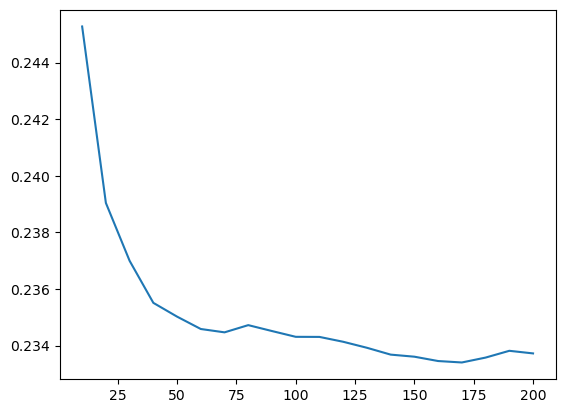

In [158]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

without rounding up (df_scores.rmse.round(3), I get a clearer view of how the score diminishes. it stops increasing at about 190, but this option isn't available hence my selection of 160.

## Question 4:

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth:

- 10
- 15
- 20
- 25

In [159]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1,
                                  max_depth=d, n_jobs=-1)
        rf.fit(X_train, y_train)
        # Make prediction on validation
        y_pred = rf.predict(X_val)
        mean_error = rmse(y_val, y_pred)
        scores.append((d, n, mean_error))

In [160]:
columns=['max_depth','n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
3,10,40,0.245168
4,10,50,0.245557
...,...,...,...
75,25,160,0.233417
76,25,170,0.233433
77,25,180,0.233606
78,25,190,0.233846


In [161]:
df_scores[df_scores.rmse == df_scores.rmse.max()]

,max_depth,n_estimators,rmse
0,10,10,0.250677


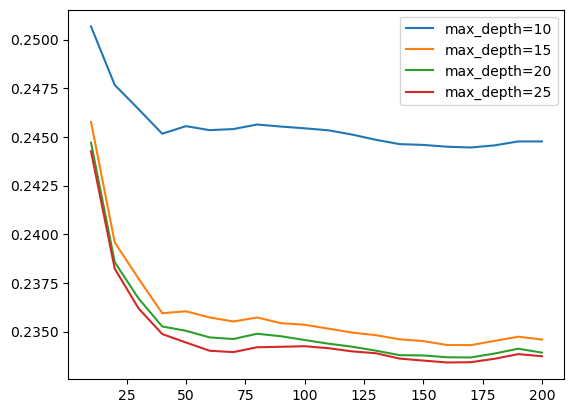

In [162]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, 
             label='max_depth=%d' % d)
    
plt.legend()

## Question 5: 
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)

- Get the feature importance information from this model

What's the most important feature (among these 4)?

- total_rooms
- median_income
- total_bedrooms
- longitude

In [163]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth= 20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [164]:
rf.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [165]:
# Get names for each feature and its score
df_impt = pd.DataFrame()
df_impt['feature'] = dv.get_feature_names_out()
df_impt['importance'] = rf.feature_importances_
df_impt

,feature,importance
0,households,0.015136
1,housing_median_age,0.030317
2,latitude,0.102007
3,longitude,0.086244
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
6,ocean_proximity=INLAND,0.073806
7,population,0.027136
8,total_bedrooms,0.015852
9,total_rooms,0.021417


In [166]:
df_impt.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806


The most important feature is the median_income, followed by ocean_proximity, which is also the split feature as per question 1 above.

## Question 6:
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value

In [167]:
import xgboost as xgb

In [168]:
features = dv.get_feature_names_out()
features 

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [169]:
features = ['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity_1H_OCEAN',
       'ocean_proximity_INLAND', 'population', 'total_bedrooms',
       'total_rooms']

In [170]:
# create Dmatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [171]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [177]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train=float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))

#     Turn into a dataframe
    columns = ['num_iter', 'train_rmse', 'val_rmse']  
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [178]:
scores = {}

In [179]:
%%capture output
xgb_params = { 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1,
                'objective': 'reg:squarederror',
                'nthread': 8,

                'seed': 1,
                'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                 evals=watchlist)

In [180]:
scores['eta=0.3'] = parse_xgb_output(output)

Now change eta from 0.3 to 0.1.

In [181]:
%%capture output
xgb_params = { 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1,
                'objective': 'reg:squarederror',
                'nthread': 8,

                'seed': 1,
                'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 verbose_eval=5,
                 evals=watchlist)

In [182]:
scores['eta=0.1'] = parse_xgb_output(output)

In [183]:
scores['eta=0.1']

,num_iter,train_rmse,val_rmse
0,0,10.37456,10.37545
1,5,6.13433,6.13236
2,10,3.63299,3.62939
3,15,2.15901,2.15616
4,20,1.29412,1.29329
5,25,0.78993,0.79342
6,30,0.50217,0.51149
7,35,0.34590,0.36371
8,40,0.26743,0.29345
9,45,0.23014,0.26315


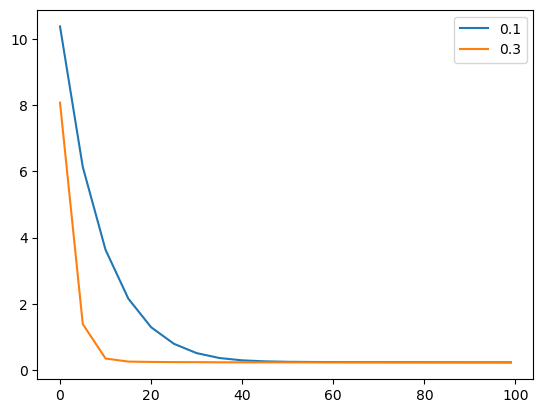

In [185]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label=0.1)
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label=0.3)
plt.legend()